# Factor Analysis

## Preprocess

In [27]:
# load packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from factor_analyzer import factor_analyzer, Rotator
from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity
import warnings

warnings.filterwarnings("ignore")

In [2]:
# read file
adl_path = "../data/data_adl.pkl"
df = pd.read_pickle(adl_path)

In [3]:
# bartlett and kmo test
kmo = calculate_kmo(df)
bartlett = calculate_bartlett_sphericity(df)
print("Factor Analysis Suitability Test")
print("KMO: {:.4f}\tBartlett: {:.4f}".format(kmo[1], bartlett[1]))
if kmo[1] > 0.9 and bartlett[1] < 0.05:
    print("FA suitability test passes!")

Factor Analysis Suitability Test
KMO: 0.9428	Bartlett: 0.0000
FA suitability test passes!


## Function Definition

In [4]:
def factor_analysis(df, factor=1, rot=None, m="principal"):
    fa = FactorAnalyzer(n_factors=factor, method=m, rotation=rot)
    fa.fit(df)
    return fa

In [5]:
def scree_plot(df, original=True, method="principal", plot=True):
    fa = factor_analysis(df, df.shape[1], rot=None, m=method)
    ev = np.array(fa.get_eigenvalues()).T
    df_ev = pd.DataFrame(ev, columns=["Original Eigenvalues", "Common Factor Eigenvalues"], index=df.columns)
    if plot:
        ev_dat = df_ev.iloc[:, 0].copy() if original else df_ev.iloc[:, 1].copy()
        plt.scatter(range(1, df.shape[1]+1), ev_dat)
        plt.plot(range(1, df.shape[1]+1), ev_dat)
        plt.title('Scree Plot')
        plt.xlabel('Factors')
        plt.ylabel('Eigenvalue')
        plt.grid()
        plt.show()
    return df_ev

In [19]:
def variance_explained_plot(df, var_type=0, method="principal", plot=True):
    fa = factor_analysis(df, df.shape[1], rot=None, m=method)
    var = np.array(fa.get_factor_variance()).T
    df_var = pd.DataFrame(var, columns=["Variance", "Proportional Variance", "Cumulative Variance"], index=df.columns)
    var_list = [df_var[i] for i in df_var.columns]
    if plot:
        var_dat = var_list[var_type]
        plt.scatter(range(1, df.shape[1]+1), var_dat)
        plt.plot(range(1, df.shape[1]+1), var_dat)
        plt.title(f'{var_dat.name} Plot')
        plt.xlabel('Factors')
        plt.ylim((0, 1))
        plt.grid()
        plt.show()
    var, pvar, cvar = var_list
    return var, pvar, cvar

In [7]:
def fa_result(df, fa):
    cols = [("Factor" + str(i+1)) for i in range(fa.loadings_.shape[1])]
    loadings = pd.DataFrame(fa.loadings_, columns=cols, index=df.columns)
    communalities = pd.DataFrame(fa.get_communalities(), columns=["Communalities"], index=df.columns)
    uniquenesses = pd.DataFrame(fa.get_uniquenesses(), columns=["Uniquenesses"], index=df.columns)
    result = pd.concat([loadings, communalities, uniquenesses], axis=1)
    score = pd.DataFrame(fa.transform(df))
    return result, score

In [49]:
def loadings_plot(df, title=""):
    col_num = len(df.columns)
    if col_num == 2:
        plt.scatter(df[df.columns[0]], df[df.columns[1]])
        for i in range(df.shape[0]):
            plt.text(x=df[df.columns[0]][i], y=df[df.columns[1]][i], s=df.index[i])
        if title:
            plt.title(title)
        else:
            plt.title("Loadings Plot")
        plt.xlabel("Factor1")
        plt.ylabel("Factor2")
        plt.axvline(x=0, color='blue')
        plt.axhline(y=0, color='blue')
        plt.show()

## PCFA

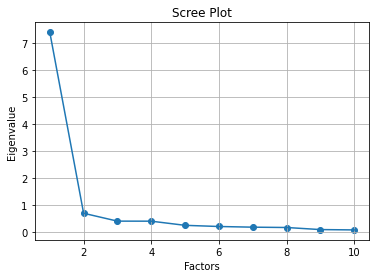

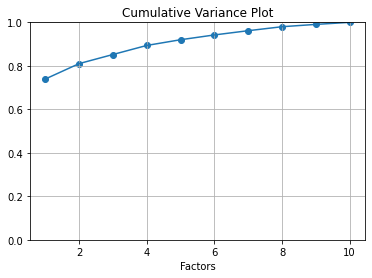

In [20]:
pcfa_ev = scree_plot(df)
pcfa_var, pcfa_pvar, pcfa_cvar = variance_explained_plot(df, var_type=2)

In [22]:
pc_result, pc_score, pc_label = [], [], []
lbl = "pcfa"
for i in range(1, 4):
    for rotation in [None, "varimax"]:
        tmp_lbl = lbl + str(i)
        pcfa = fa_result(df, factor_analysis(df, factor=i, rot=rotation))
        pc_result.append(pcfa[0])
        pc_score.append(pcfa[1])
        if rotation:
            tmp_lbl = tmp_lbl + "_" + rotation
        pc_label.append(tmp_lbl)

In [67]:
for i in range(len(pc_score)):
    df = pc_score[i].to_numpy()
    with open(f"../npy/data_adl_{pc_label[i]}.npy", 'wb') as f:
        np.save(f, df)

## MLFA

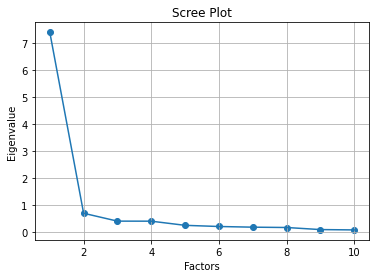

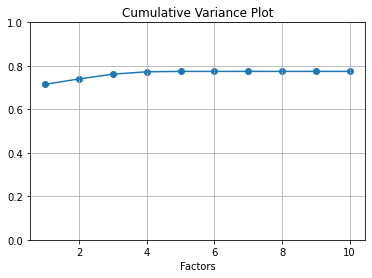

In [21]:
mlfa_ev = scree_plot(df, method="ml")
mlfa_var, mlfa_pvar, mlfa_cvar = variance_explained_plot(df, var_type=2, method="ml")

In [23]:
ml_result, ml_score, ml_label = [], [], []
lbl = "mlfa"
for i in range(1, 4):
    for rotation in [None, "varimax", "oblimin"]:
        tmp_lbl = lbl + str(i)
        mlfa = fa_result(df, factor_analysis(df, factor=i, rot=rotation, m="ml"))
        ml_result.append(mlfa[0])
        ml_score.append(mlfa[1])
        if rotation:
            tmp_lbl = tmp_lbl + "_" + rotation
        ml_label.append(tmp_lbl)

In [69]:
for i in range(len(ml_score)):
    df = ml_score[i].to_numpy()
    with open(f"../npy/data_adl_{ml_label[i]}.npy", 'wb') as f:
        np.save(f, df)

## Analysis

In [62]:
pc_score[3]

,0,1
0,-0.943011,0.208695
1,3.573965,0.901020
2,-0.079943,0.255419
3,-0.648182,0.127471
4,-0.434582,-0.840839
...,...,...
25389,-0.585841,-0.382892
25390,-0.693681,-1.159858
25391,2.020751,-0.915735
25392,0.899448,0.110161


In [25]:
print(pc_label)
print(ml_label)

['pcfa1', 'pcfa1_varimax', 'pcfa2', 'pcfa2_varimax', 'pcfa3', 'pcfa3_varimax']
['mlfa1', 'mlfa1_varimax', 'mlfa1_oblimin', 'mlfa2', 'mlfa2_varimax', 'mlfa2_oblimin', 'mlfa3', 'mlfa3_varimax', 'mlfa3_oblimin']


In [43]:
pc_result[3]

,Factor1,Factor2,Communalities,Uniquenesses
H2a,0.855200,0.228555,0.783605,0.216395
H2b,0.838628,0.369868,0.840099,0.159901
H2c,0.729628,0.519625,0.802367,0.197633
H2d,0.230227,0.942431,0.941181,0.058819
H2e,0.855371,0.312740,0.829466,0.170534
H2f,0.835082,0.377862,0.840142,0.159858
H2g,0.833563,0.135576,0.713209,0.286791
H2h,0.805206,0.404414,0.811908,0.188092
H2i,0.857963,0.240998,0.794180,0.205820
H2j,0.737994,0.449890,0.747036,0.252964


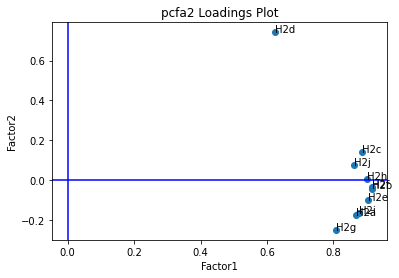

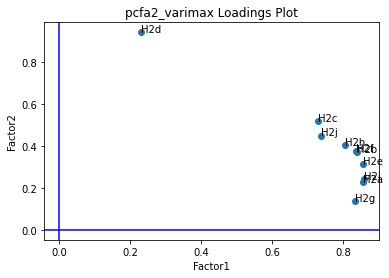

In [56]:
loadings_plot(pc_result[2][["Factor1", "Factor2"]], f"{pc_label[2]} Loadings Plot")
loadings_plot(pc_result[3][["Factor1", "Factor2"]], f"{pc_label[3]} Loadings Plot")

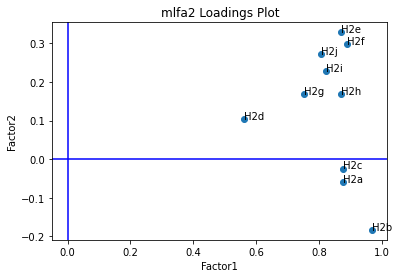

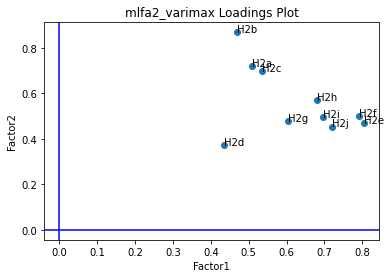

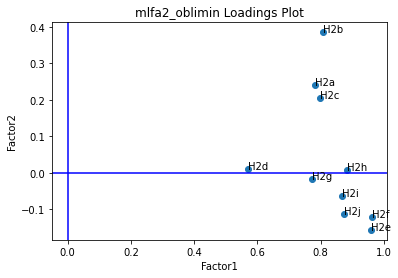

In [57]:
loadings_plot(ml_result[3][["Factor1", "Factor2"]], f"{ml_label[3]} Loadings Plot")
loadings_plot(ml_result[4][["Factor1", "Factor2"]], f"{ml_label[4]} Loadings Plot")
loadings_plot(ml_result[5][["Factor1", "Factor2"]], f"{ml_label[5]} Loadings Plot")

In [ ]:
# fig = plt.figure(figsize=(12, 12))
# gs = mpl.gridspec.GridSpec(3, len(pc_label) // 3)
# ax = [ax1, ax2, ax3, ax4, ax5, ax6] = [None] * len(pc_label)
# for factor_num in range(3):
#     for j in range(len(pc_label) // 3):
#         index = factor_num * 3 + j
#         if index >= len(pc_label):
#             break
#         ax[index] = plt.subplot(gs[factor_num, j])
#         plt.title(pc_label[index])
#         if factor_num == 0:
#             loadings_plot(pc_result[index][["Factor1"]])
#         elif factor_num == 1:
#             loadings_plot(pc_result[index][["Factor1", "Factor2"]])
#         elif factor_num == 2:
#             loadings_plot(pc_result[index][["Factor1", "Factor2", "Factor3"]])
#         plt.show()
# gs.tight_layout(plt.gcf())